##### This version of ResNet only trains on 20 Epochs

##### 1. **Import Libraries**

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import multiprocessing
import os
import random
from PIL import Image
import logging
import cv2
import numpy as np

##### 2. **Set up environment**

In [10]:
# Enable multiprocessing support
multiprocessing.freeze_support()

# Set up logging
logging.basicConfig(level=logging.INFO)

# Set up the device
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        return torch.device("mps")  # For Apple GPUs
    else:
        return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")

# Define path to dataset
data_dir = '../../dataset_26'

Using device: cpu


##### 3. **Data Preparation & Preprocessing**

In [11]:
def crop_image(image):
    """
    Crop the brain MRI image to focus on the region of interest.
    This function uses contour detection to identify and crop the main brain area.
    """
    try:
        img_array = np.array(image)
        img_gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
        img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
        
        _, img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)
        img_thresh = cv2.erode(img_thresh, None, iterations=2)
        img_thresh = cv2.dilate(img_thresh, None, iterations=2)

        contours, _ = cv2.findContours(img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if contours:
            c = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(c)
            cropped_image = img_array[y:y+h, x:x+w]
            return Image.fromarray(cropped_image)
        else:
            return image
    except Exception as e:
        logging.error(f"Error in crop_image: {str(e)}")
        return image

class CustomDataset(torch.utils.data.Dataset):
    """
    Custom dataset class for loading and preprocessing brain MRI images.
    Applies different transformations for training and testing data.
    """
    def __init__(self, image_paths, labels, transform=None, is_train=False):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.is_train = is_train

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.image_paths[idx]).convert('RGB')
            if self.is_train:
                image = crop_image(image)
            label = self.labels[idx]
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            logging.error(f"Error loading image {self.image_paths[idx]}: {str(e)}")
            placeholder_image = torch.zeros((3, 224, 224))
            return placeholder_image, self.labels[idx]

def prepare_data(data_dir, batch_size=32):
    """
    Prepare the data for training, validation, and testing.
    This function:
    1. Defines data transformations
    2. Loads and splits the data into train, validation, and test sets
    3. Creates DataLoader objects for each set
    """
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    class_names = []
    train_data, val_data, test_data = [], [], []

    for class_idx, class_name in enumerate(sorted(os.listdir(data_dir))):
        class_names.append(class_name)
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        image_paths = []
        for img in os.listdir(class_dir):
            if img.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_dir, img)
                try:
                    with Image.open(img_path) as img:
                        img.verify()
                    image_paths.append(img_path)
                except Exception as e:
                    logging.error(f"Error processing image {img_path}: {str(e)}")

        random.shuffle(image_paths)

        total = len(image_paths)
        train_split = int(0.7 * total)
        val_split = int(0.2 * total)

        train_data.extend([(img, class_idx) for img in image_paths[:train_split]])
        val_data.extend([(img, class_idx) for img in image_paths[train_split:train_split+val_split]])
        test_data.extend([(img, class_idx) for img in image_paths[train_split+val_split:]])

    train_dataset = CustomDataset([x[0] for x in train_data], [x[1] for x in train_data], transform=train_transform, is_train=True)
    val_dataset = CustomDataset([x[0] for x in val_data], [x[1] for x in val_data], transform=val_test_transform)
    test_dataset = CustomDataset([x[0] for x in test_data], [x[1] for x in test_data], transform=val_test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    print(f"Train set size: {len(train_dataset)}")
    print(f"Validation set size: {len(val_dataset)}")
    print(f"Test set size: {len(test_dataset)}")

    return train_loader, val_loader, test_loader, class_names

print("Preparing data...")
batch_size = 32
train_loader, val_loader, test_loader, class_names = prepare_data(data_dir, batch_size)
print("Data preparation completed.")


Preparing data...
Train set size: 336
Validation set size: 96
Test set size: 48
Data preparation completed.


##### 4. **Configure the ResNet Model**

In [12]:
class BrainMRIResNet(nn.Module):
    """
    Define the ResNet model architecture by modifying a pre-trained ResNet50
    """
    def __init__(self, num_classes=4):
        super(BrainMRIResNet, self).__init__()
        self.resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout for regularization
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.resnet(x)

##### 5. **Train the Model**

In [13]:
def train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, patience=5, model_name='brain_mri_model'):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Save the best model and check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'best_{model_name}.pth')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping triggered after epoch {epoch+1}")
                break

    return train_losses, val_losses, train_accuracies, val_accuracies


# Set up the training
def setup_and_train(train_loader, val_loader, test_loader, class_names, num_epochs=20, model_name='brain_mri_model'):
    try:
        model = BrainMRIResNet(num_classes=len(class_names))
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
        
        model.to(device)
        
        train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate_model(
            model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, model_name=model_name
        )
        
        return model, train_losses, val_losses, train_accuracies, val_accuracies
    except Exception as e:
        logging.error(f"An error occurred during setup and training: {str(e)}")
        raise

# Execute training
print("Starting model training for 20 epochs...")
model_20, train_losses_20, val_losses_20, train_accuracies_20, val_accuracies_20 = setup_and_train(
    train_loader, val_loader, test_loader, class_names, num_epochs=20, model_name='brain_mri_model_20epochs'
)
print("20-epoch model training completed.")

Starting model training for 20 epochs...
Epoch 1/20, Train Loss: 1.1954, Train Acc: 44.35%, Val Loss: 5.1563, Val Acc: 35.42%
Epoch 2/20, Train Loss: 0.9027, Train Acc: 63.69%, Val Loss: 2.5802, Val Acc: 56.25%
Epoch 3/20, Train Loss: 0.9714, Train Acc: 67.26%, Val Loss: 0.9343, Val Acc: 66.67%
Epoch 4/20, Train Loss: 0.8849, Train Acc: 65.18%, Val Loss: 0.9338, Val Acc: 70.83%
Epoch 5/20, Train Loss: 0.6877, Train Acc: 71.73%, Val Loss: 0.6811, Val Acc: 79.17%
Epoch 6/20, Train Loss: 0.5995, Train Acc: 78.87%, Val Loss: 0.4788, Val Acc: 84.38%
Epoch 7/20, Train Loss: 0.6462, Train Acc: 77.68%, Val Loss: 0.8447, Val Acc: 71.88%
Epoch 8/20, Train Loss: 0.5258, Train Acc: 78.57%, Val Loss: 1.2072, Val Acc: 60.42%
Epoch 9/20, Train Loss: 0.6574, Train Acc: 75.60%, Val Loss: 0.6271, Val Acc: 83.33%
Epoch 10/20, Train Loss: 0.6077, Train Acc: 75.30%, Val Loss: 1.0025, Val Acc: 67.71%
Epoch 11/20, Train Loss: 0.5208, Train Acc: 80.65%, Val Loss: 0.4676, Val Acc: 85.42%
Epoch 12/20, Train Los

##### 6. **Evaluate Model Performance**

Plotting training history for 20-epoch model...


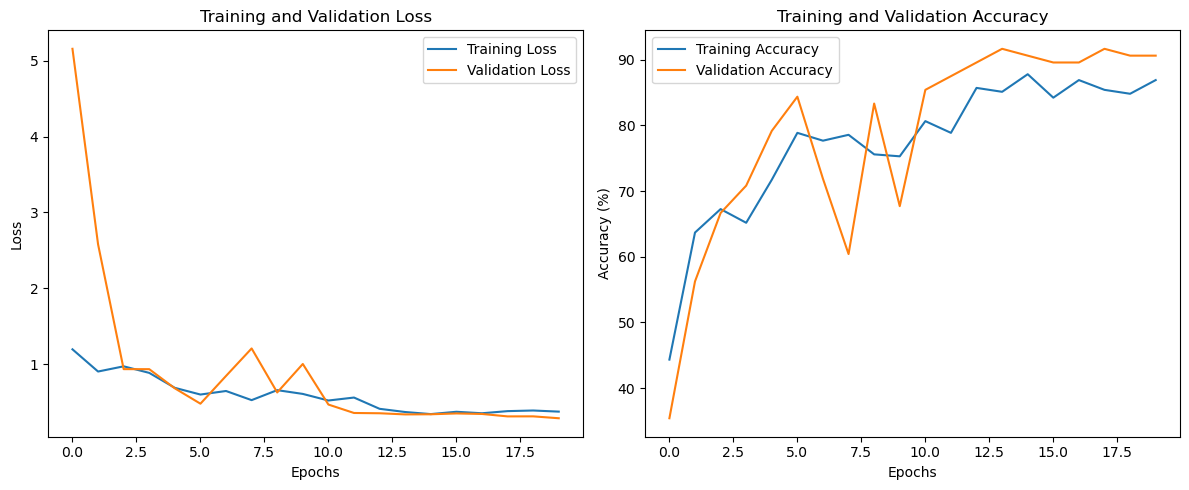

Evaluating 20-epoch model performance...

Classification Report on Test Set:
              precision    recall  f1-score   support

      glioma     1.0000    0.9167    0.9565        12
  meningioma     0.6000    1.0000    0.7500        12
     notumor     1.0000    0.4167    0.5882        12
   pituitary     0.9167    0.9167    0.9167        12

    accuracy                         0.8125        48
   macro avg     0.8792    0.8125    0.8029        48
weighted avg     0.8792    0.8125    0.8029        48


Overall Accuracy on Test Set: 81.25%


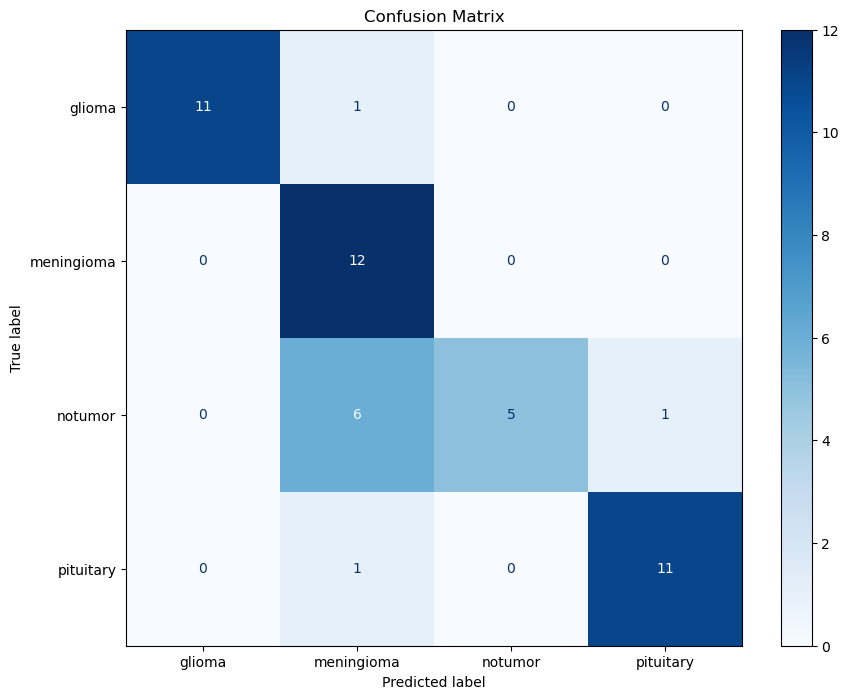

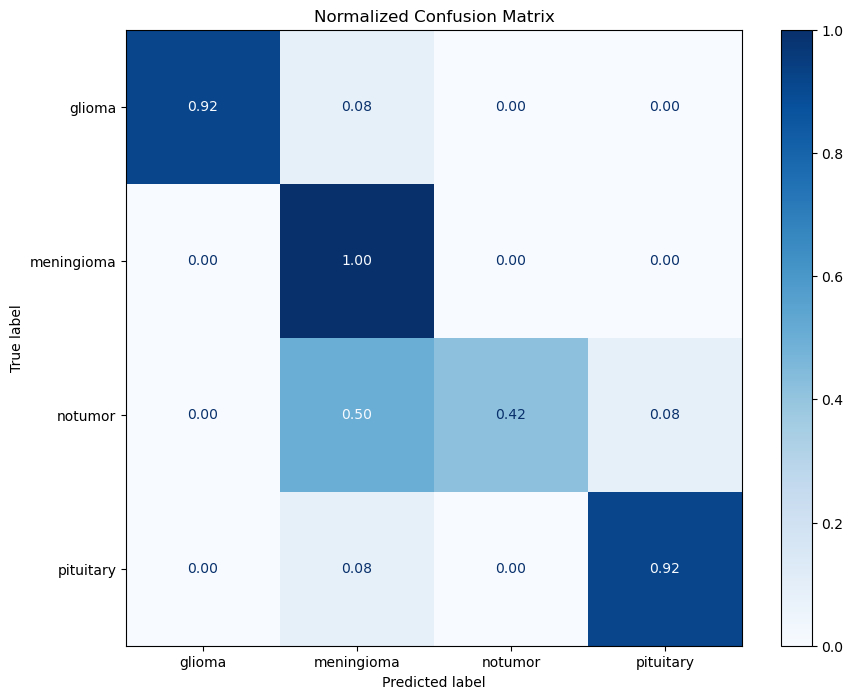

In [14]:
def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Print classification report
    print("\nClassification Report on Test Set:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))
    
    # Calculate overall accuracy
    accuracy = (100.0 * sum([1 for p, t in zip(all_preds, all_labels) if p == t])) / len(all_preds)
    print(f"\nOverall Accuracy on Test Set: {accuracy:.2f}%")
    
    # Plot confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names)

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def plot_confusion_matrix(true_labels, predictions, class_names):
    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    
    # Create the ConfusionMatrixDisplay object
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title('Confusion Matrix')
    plt.show()
    
    # Plot normalized confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp_norm.plot(cmap=plt.cm.Blues, ax=ax, values_format='.2f')
    plt.title('Normalized Confusion Matrix')
    plt.show()

print("Plotting training history for 20-epoch model...")    
plot_training_history(train_losses_20, val_losses_20, train_accuracies_20, val_accuracies_20)

print("Evaluating 20-epoch model performance...")
evaluate_model(model_20, test_loader, device, class_names)